 # Clasificación de Imágenes con CLIP
 

## Descripción General

Este notebook está diseñado para realizar la inferencia de clasificación de imágenes utilizando el modelo CLIP (Contrastive Language Image Pretraining) de OpenAI. CLIP es un modelo poderoso capaz de entender imágenes y texto en un espacio compartido, lo que permite realizar búsquedas y clasificaciones de imágenes basadas en descripciones textuales.

## Escenario y Uso

El escenario específico de este notebook se centra en clasificar un conjunto de imágenes no etiquetadas en categorías predefinidas basadas en un conjunto de imágenes de referencia que han sido previamente etiquetadas. Esto es particularmente útil en situaciones donde se dispone de un gran volumen de imágenes sin etiquetar y se quiere clasificar automáticamente en categorías conocidas.

## Estructura del Proyecto

El proyecto está estructurado de la siguiente manera:
- `datasets`: Carpeta que contiene los conjuntos de datos, incluyendo las imágenes de referencia etiquetadas y las imágenes sin etiquetar para la inferencia.

Cada dataset dentro de la carpeta `datasets` debería tener una estructura específica y contener un archivo `config.json` con información relevante, como la región de interés (ROI) para las imágenes, si es aplicable.

## Requisitos

Este notebook asume que ya se ha realizado un proceso previo de capacitación o se ha configurado el modelo CLIP con las imágenes de referencia necesarias para la clasificación. Es necesario contar con las siguientes librerías instaladas:
- `torch`
- `sentence_transformers`
- `numpy`
- `PIL`
- `matplotlib`

## Configuración Inicial

En la primera sección de este notebook, estableceremos la configuración inicial, cargaremos el modelo CLIP y prepararemos todo para la inferencia de clasificación de imágenes.


In [47]:
# Importar librerías necesarias
import os
import json
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Establecer la configuración del dispositivo (CPU o GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo seleccionado: {device}")

# Definir las rutas a los directorios relevantes
datasets_path = "./datasets"  # Asegúrate de ajustar esto a tu estructura de directorios
os.makedirs(results_path, exist_ok=True)

# Solicitar al usuario que ingrese el nombre del dataset
dataset_name = input("Por favor, ingresa el nombre del dataset con el que deseas trabajar: ")
dataset_path = os.path.join(datasets_path, dataset_name)

# Verificar que el dataset existe
if not os.path.exists(dataset_path):
    raise ValueError("El dataset especificado no existe. Por favor, verifica el nombre e inténtalo de nuevo.")

# Cargar la configuración del dataset y la ROI (si existe)
config_file_path = os.path.join(dataset_path, 'config.json')
if os.path.exists(config_file_path):
    with open(config_file_path, 'r') as f:
        config = json.load(f)
    roi = config.get('roi', None)
    print("Configuración y ROI cargadas con éxito.")
    print(roi)
else:
    roi = None
    print("No se encontró archivo de configuración. Se continuará sin ROI.")

# Cargar el modelo CLIP
clip_model_name = "clip-ViT-B-32"
model = SentenceTransformer(clip_model_name, device=device, cache_folder='./cache_models')
print("Modelo CLIP cargado con éxito.")

Dispositivo seleccionado: cuda


Por favor, ingresa el nombre del dataset con el que deseas trabajar:  jeansel


Configuración y ROI cargadas con éxito.
{'x': 0, 'y': 800, 'height': 300, 'width': 300}
Modelo CLIP cargado con éxito.


# Funciones de Apoyo

In [48]:
import numpy as np
from PIL import Image
from sentence_transformers import util
import os
import json

def cargar_embeddings(embeddings_path):
    embeddings = {}    
    class_folders = [f for f in os.listdir(embeddings_path) if not f.startswith('.') and os.path.isdir(os.path.join(embeddings_path, f))]
    for class_folder in class_folders:
        class_path = os.path.join(embeddings_path, class_folder)
        if os.path.isdir(class_path):
            embeddings[class_folder] = []
            for embedding_file in os.listdir(class_path):
                if embedding_file.endswith('.npy'):
                    embedding_path = os.path.join(class_path, embedding_file)
                    embedding = np.load(embedding_path)
                    embeddings[class_folder].append(embedding)
    return embeddings

def aplicar_roi(imagen, roi):
    if roi:
        x, y, width, height = roi['x'], roi['y'], roi['width'], roi['height']
        imagen = imagen.crop((x, y, x + width, y + height))
    return imagen

def clasificar_imagen(imagen, embeddings, model, mode='avg'):
    img_embedding = model.encode(imagen).astype(float)
    similarities = {}
    for class_name, class_embeddings in embeddings.items():
        cos_scores_total = 0
        max_value = 0
        for class_embedding in class_embeddings:
            cos_scores = util.cos_sim(img_embedding, class_embedding)
            cos_scores_total += cos_scores
            max_value = max(max_value, cos_scores)
        if mode == 'max':
            similarities[class_name] = max_value
        elif mode == 'avg':
            similarities[class_name] = cos_scores_total / len(class_embeddings)
    
    # Retorna la clase con la mayor similitud
    return max(similarities, key=similarities.get)


 # Inferencia, Clasificación y Creación del Nuevo Dataset
    

In [49]:
import shutil
from tqdm import tqdm

CONVERT_2_PNG = True

# Cargar la configuración y los embeddings
embeddings_path = os.path.join(dataset_path, 'Classes')
embeddings = cargar_embeddings(embeddings_path)

# Directorio de imágenes a clasificar
image_folder_path = os.path.join(dataset_path, 'Images')

# Directorio para el nuevo dataset
new_dataset_path = os.path.join(dataset_path, "nuevo_dataset")
os.makedirs(new_dataset_path, exist_ok=True)

# Procesar cada imagen, clasificarla y moverla a la carpeta correspondiente
for img_name in tqdm(os.listdir(image_folder_path), desc="Procesando imágenes"):
    img_path = os.path.join(image_folder_path, img_name)

    # Saltar si es un directorio
    if os.path.isdir(img_path):
        # print(f"Se encontró un directorio, se omite: {img_path}")
        continue
    
    # Cargar y procesar la imagen
    img = Image.open(img_path)
    roi_img = aplicar_roi(img, roi)
    
    # Clasificar la imagen
    predicted_class = clasificar_imagen(roi_img, embeddings, model)
    if predicted_class is None:
        print(f"No se pudo clasificar la imagen: {img_name}")
        continue
    
    # Crear la carpeta para la clase predicha si no existe
    class_folder_path = os.path.join(new_dataset_path, predicted_class)
    os.makedirs(class_folder_path, exist_ok=True)
    
    
    if(CONVERT_2_PNG):
    
        # Cambiar el formato de la imagen a PNG
        new_img_name = os.path.splitext(img_name)[0] + '.png'
        new_img_path = os.path.join(class_folder_path, new_img_name)

        # Guardar la imagen en formato PNG en la carpeta de la clase predicha
        img.save(new_img_path, format='PNG')
        
    else:
        
        # Copiar la imagen a la carpeta de la clase predicha
        shutil.copy(img_path, os.path.join(class_folder_path, img_name))
                

print("Proceso completado. Imágenes clasificadas y organizadas en el nuevo dataset.")


Procesando imágenes: 100%|██████████| 211/211 [03:29<00:00,  1.01it/s]

Proceso completado. Imágenes clasificadas y organizadas en el nuevo dataset.


## Visualización de Algunas Imágenes Clasificadas

Clase: left gap


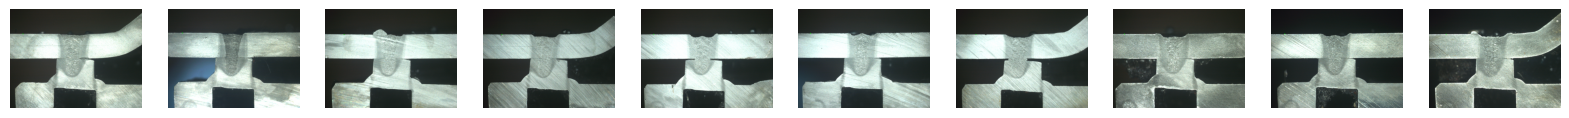

Clase: right gap


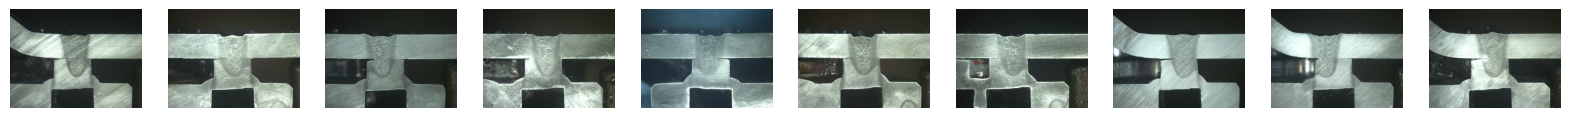

In [50]:
import random
import matplotlib.pyplot as plt

def mostrar_imagenes_aleatorias(class_folder_path, num_images=10):
    """Muestra num_images imágenes aleatorias de una carpeta específica."""
    image_files = [f for f in os.listdir(class_folder_path) if os.path.isfile(os.path.join(class_folder_path, f))]
    sample_images = random.sample(image_files, min(len(image_files), num_images))

    fig, axs = plt.subplots(1, len(sample_images), figsize=(20, 2))
    for ax, img_file in zip(axs, sample_images):
        img_path = os.path.join(class_folder_path, img_file)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Por cada clase en el nuevo dataset, mostrar imágenes aleatorias
for class_name in os.listdir(new_dataset_path):
    class_folder_path = os.path.join(new_dataset_path, class_name)
    if os.path.isdir(class_folder_path):
        print(f"Clase: {class_name}")
        mostrar_imagenes_aleatorias(class_folder_path)
